# Notebook and python basics

The jupyter notebook is an interactive python environment that enables users to enter and execute commands in "cells," much like the matlab interactive environment.  We use it primarily as a teaching tool, since live coding is much easier to follow in the notebook and markdown documentation can be inserted inline.  Here, we cover a few basic features of the notebook environment and python before we begin with any of the materials science.

To execute a cell, you can either click the "play" button in the toolbar, or press `shift+enter` while the cell is active.  For example:

# Pymatgen core functionality

Pymatgen is the code that powers all of the analysis that's used in the Materials Project.  It includes a robust and efficient libraries for the handling of structures and molecules, in addition to various mathematical and scientific tools for the handling and generation of materials data.  Here are a few things you can do with pymatgen:

- Create, identify, and manipulate crystal structures and molecules
- Write input and output files for most electronic structure codes
- Analyze density of states, XRD spectra, and bandstructure data
- Tensor-based analysis, including Elastic and Piezoelectric tensors
- Analysis of the local chemical environment of structural sites
- Create pourbaix and phase diagrams
- Match substrates based on geometry and elastic behavior
- Create and manipulate surfaces
- Do unit conversions
- Get basic information about chemical identity
- Estimate the cost of a material based on chemical abundance

## Structures, sites, and lattices

Most of the fundamentals of pymatgen are expressed in the Structure and Lattice objects.  These objects contain data on the lattice parameters and the location of individual sites within lattices.  Let's start by importing those objects.

In [3]:
from pymatgen import Structure, Lattice, Molecule

The general lattice constructor takes a 3x3 array as it's argument, which consists of the vectors that compose the unit cell.  There are also convenience constructors that allow you to construct lattices from lengths and angles, as well as from specific crystal systems with appropriate input parameters.

In [4]:
# Making lattices
lattice = Lattice([[2.8, 0, 0], [0, 2.8, 0], [0, 0, 2.8]])
lattice = Lattice.from_lengths_and_angles([2.8, 2.8, 2.8], [90, 90, 90])
lattice.cubic(2.8)

lattice.hexagonal(a = 2.8, c = 3.6)
lattice.rhombohedral(a = 2.8, alpha = 60)

# Getting lattice info
print("a = ", lattice.a)
print("alpha = ", lattice.alpha)
print("volume = ", lattice.volume)

a =  2.8
alpha =  90.0
volume =  21.951999999999995


In [5]:
# The general lattice constructor takes a 3x3 array as it's argument, which consists of the vectors that compose the unit cell.  There are also convenience constructors that allow you to construct lattices from lengths and angles, as well as from specific crystal systems with appropriate input parameters.

#### Creating Structures 
Structures objects are lattices with the addition of contained species. Structures can be constructed in 3 ways: from lattice,  from spacegroups and from existing structures through cif files. 

###### From Lattices
Structures are constructed from a lattice, a list of species, and a list of coordinates that correspond to each species.  Note that species in this string can contain occupancies (and sometimes must in order to use other tools!). 

Feel free to use the above shortcuts to see what each function is capable of doing/calculating 
**Edit**


In [6]:
# Making structures
bcc_fe = Structure(lattice, ["Fe", "Fe"], [[0, 0, 0], [0.5, 0.5, 0.5]])
site0 = bcc_fe[0]
site0.coords
site0.species_string
site0.x

0.0

##### From Spacegroups
You can even create structures from Spacegroups. 

In [9]:
bcc_fe = Structure.from_spacegroup("Im-3m", Lattice.cubic(2.8), ["Fe"], [[0, 0, 0]])
print(bcc_fe)
nacl= Structure.from_spacegroup("Fm-3m", Lattice.cubic(5.692), ["Na+", "Cl-"], 
                                [[0, 0, 0], [0.5, 0.5, 0.5]])

Full Formula (Fe2)
Reduced Formula: Fe
abc   :   2.800000   2.800000   2.800000
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Fe    0    0    0
  1  Fe    0.5  0.5  0.5


##### Disordered Structures
Using spacegroups, disordered structures can also be constructed using dictionaries that correspond to the species and its occupancy.


In [11]:
# Making disordered structures
specie = {"Cu0+": 0.5, "Au0+":0.5}
cu_au = Structure.from_spacegroup("Fm-3m", Lattice.cubic(3.677), [specie], [[0, 0, 0]])
print(cu_au)

Full Formula (Cu2 Au2)
Reduced Formula: CuAu
abc   :   3.677000   3.677000   3.677000
angles:  90.000000  90.000000  90.000000
Sites (4)
  #  SP                        a    b    c
---  ----------------------  ---  ---  ---
  0  Cu0+:0.500, Au0+:0.500  0    0    0
  1  Cu0+:0.500, Au0+:0.500  0    0.5  0.5
  2  Cu0+:0.500, Au0+:0.500  0.5  0    0.5
  3  Cu0+:0.500, Au0+:0.500  0.5  0.5  0


##### From CIF Files
You can load pre-constructured structures in CIF files to use them in Pymatgen. 

In [12]:
big_structure = Structure.from_file("Nb2O5.cif")
big_structure.formula

'Nb16 O40'

##### Manipulating structures and assigning properties to sites
You can also assign site properties flexibly for different purposes like creating a supercell, adding more species and coordinates to the structure or removing extra ones. 

Tip: Try using the shortcuts stated at the top of the notebook to discover the potential of each function. 


In [13]:
big_structure[0] = "V"
big_structure.formula
big_structure[0] = "Nb"

bcc_fe.append("C", [0.25, 0.25, 0.25])
bcc_fe.pop(-1)
bcc_fe.make_supercell([2, 2, 2])

## Input/Output

Pymatgen has extensive I/O capabilities for both structures and files for electronic structure codes, including a native serialization format for nearly all of its core classes. Structure and molecule objects can be output into both friendly serialization formats (json, yaml) and a number of standard file formats automatically.  For molecules, this includes any file format supported by OpenBabel, assuming you have that dependency installed.

Here is an example of converting a given CIF file to different file formats, json and xyz. These file formats store all the information about the material.

In [15]:
bcc_fe.to("bcc_fe.cif")
bcc_fe.to(filename="bcc_fe.cif")
bcc_fe.to(filename="bcc_fe.json")

molecule = Molecule(['C', 'O'], [[0,0,0],[0, 0, 1.2]])
molecule.to(filename="molecule.xyz")

The primary way that pymatgen serializes objects for file output is via another module named "monty" (the hidden complement to python), which has two functions that will put any object with a native `as_dict` method into a json or yaml file.  A number of classes have methods that will output their contents to a file, but some don't, so you can use monty.serialization.dumpfn and loadfn to output any object with a as_dict/from_dict to a file (or read it from a file).  Here are a few examples:

In [16]:
from monty.serialization import dumpfn, loadfn
dumpfn(bcc_fe, "bcc_fe.json")
new_struct = loadfn("bcc_fe.json")
bandstructure = loadfn("li2o_bs.json")

For electronic structure and MD, pymatgen has interfaces to the following codes and I/O formats:

* abinit
* exciting
* feff
* lammps
* VASP
* adf
* aiida
* ase
* OpenBabel
* cif
* cssr
* fiesta
* gaussian
* nwchem
* phonopy
* pwscf (Quantum Espresso)
* qchem
* xcrysden
* xr
* xyz
* zeopp

---------
## SymmetryAnalyzer and Operations

In addition to bookkeeping of structures using Structure objects, pymatgen contains powerful tools for analyzing crystal symmetry and comparing structures.  The SymmetryAnalyzer object is essentially a wrapper around spglib, which is written in c for more efficient determination of invariant symmetry operations and thus crystal symmetry.  The symmetry analyzer can be used to get primitive and standardized conventional cell settings of structures.

These examples discuss how to get the primitive structure of BCC iron using SpacegroupAnalyzer and get the point group of the molecule with C and O created above using PointGroupAnalyzer

In [20]:
# Get primitive structure of BCC iron
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
sga = SpacegroupAnalyzer(bcc_fe)
prim = sga.get_primitive_standard_structure() # Note only a single site
sga.get_conventional_standard_structure()
print("Crystal system:", sga.get_crystal_system())
print("Spacegroup symbol:", sga.get_space_group_symbol())

Crystal system: cubic
Spacegroup symbol: Im-3m
Full Formula (Fe1)
Reduced Formula: Fe
abc   :   2.424871   2.424871   2.424871
angles: 109.471221 109.471221 109.471221
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Fe      0    0    0


In [24]:
ops = sga.get_space_group_operations()
pga = PointGroupAnalyzer(molecule)
pga.get_pointgroup()

C*v

--------
## XRD, Bandstructure, and Density of States

Pymatgen has various tools that allow for the analysis and plotting of structural and electronic information.  The XRDCalculator is perhaps the most straightforward of these tools, since it only requires a structure object.

The example below shows how you can easily get XRD data for the V, Nb structure we created before and the XRD plot for NaCl

In [31]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator, ATOMIC_SCATTERING_PARAMS
XRDCalculator.AVAILABLE_RADIATION
xrdc = XRDCalculator()
big_xrd = xrdc.get_pattern(big_structure)

<module 'matplotlib.pyplot' from 'C:\\Users\\princ\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

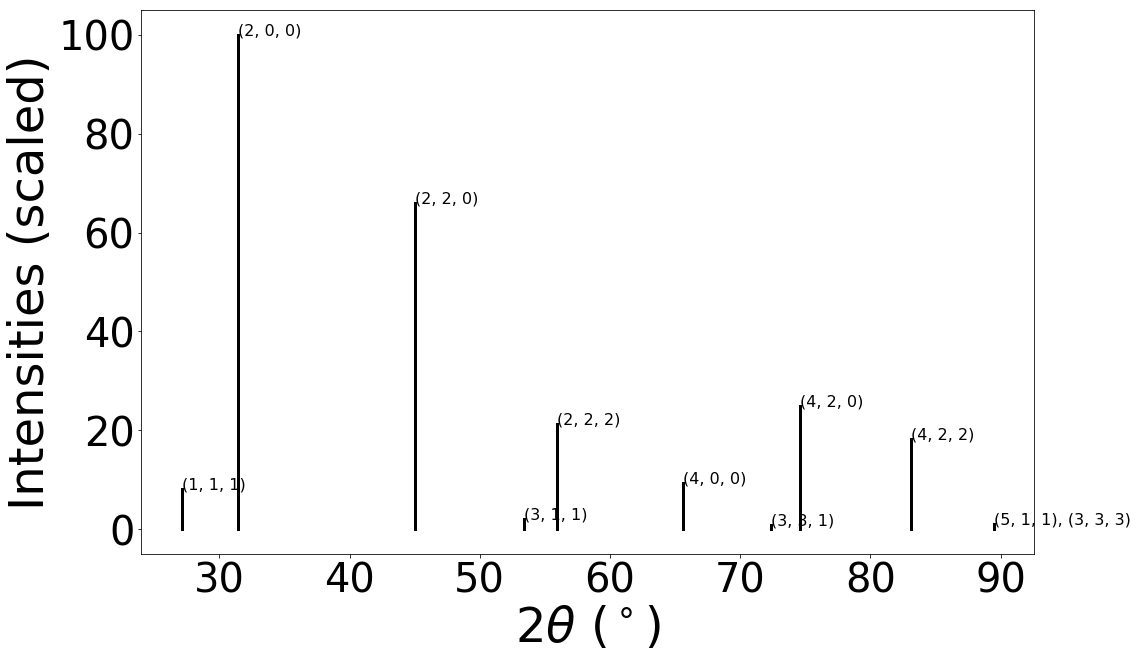

In [32]:
%matplotlib inline
xrdc.get_plot(nacl)

#### Exercise 1: XRD spectra of Li<sub>x</sub>Si<sub>y</sub>
 
Your experimental collaborator finds an interesting Li-S cathode and performs powder XRD on it, resulting in the spectra below.  Identify the structure using the pymatgen XRD calculator.
![LiS XRD](LiS_XRD.png)


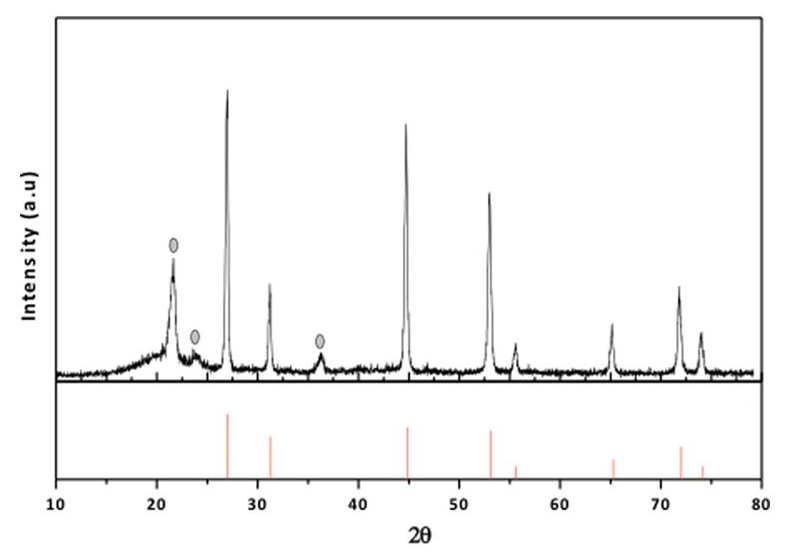

In [34]:
from IPython.display import Image
Image("LiS_XRD.png")

Full Formula (Li2 S1)
Reduced Formula: Li2S
abc   :   4.045613   4.045613   4.045613
angles:  60.000000  60.000000  60.000000
Sites (3)
  #  SP       a     b     c    coordination_no  forces
---  ----  ----  ----  ----  -----------------  ---------------
  0  Li    0.25  0.25  0.25                  8  [0.0, 0.0, 0.0]
  1  Li    0.75  0.75  0.75                  8  [0.0, 0.0, 0.0]
  2  S     0     0     0                     8  [0.0, 0.0, 0.0]


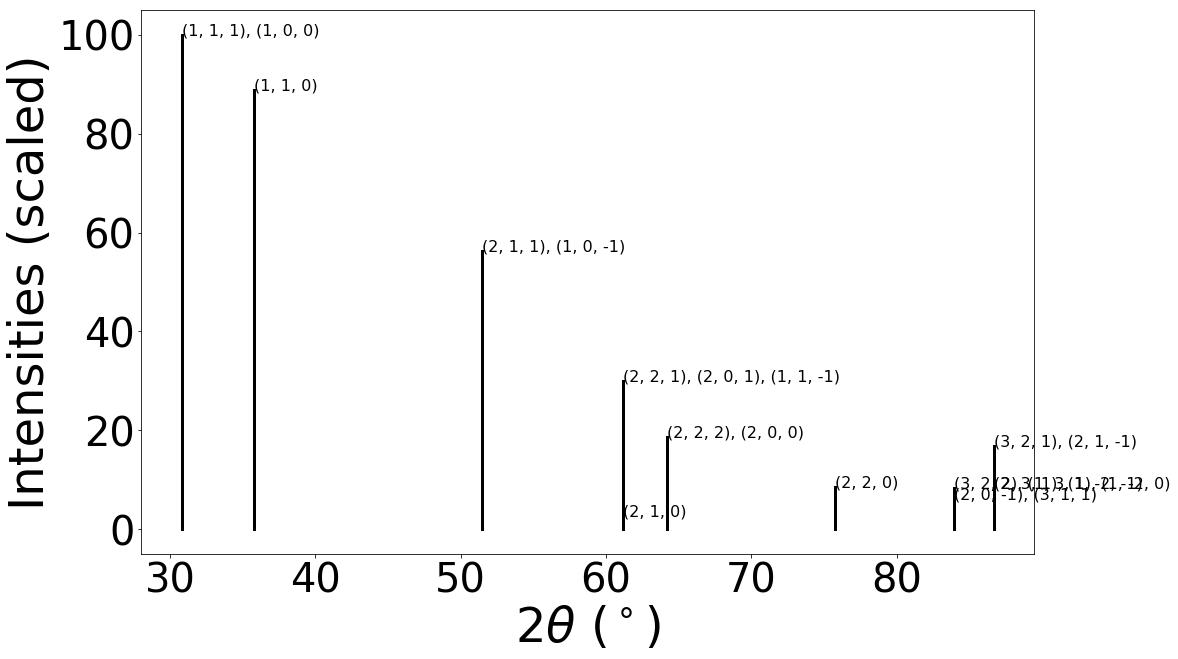

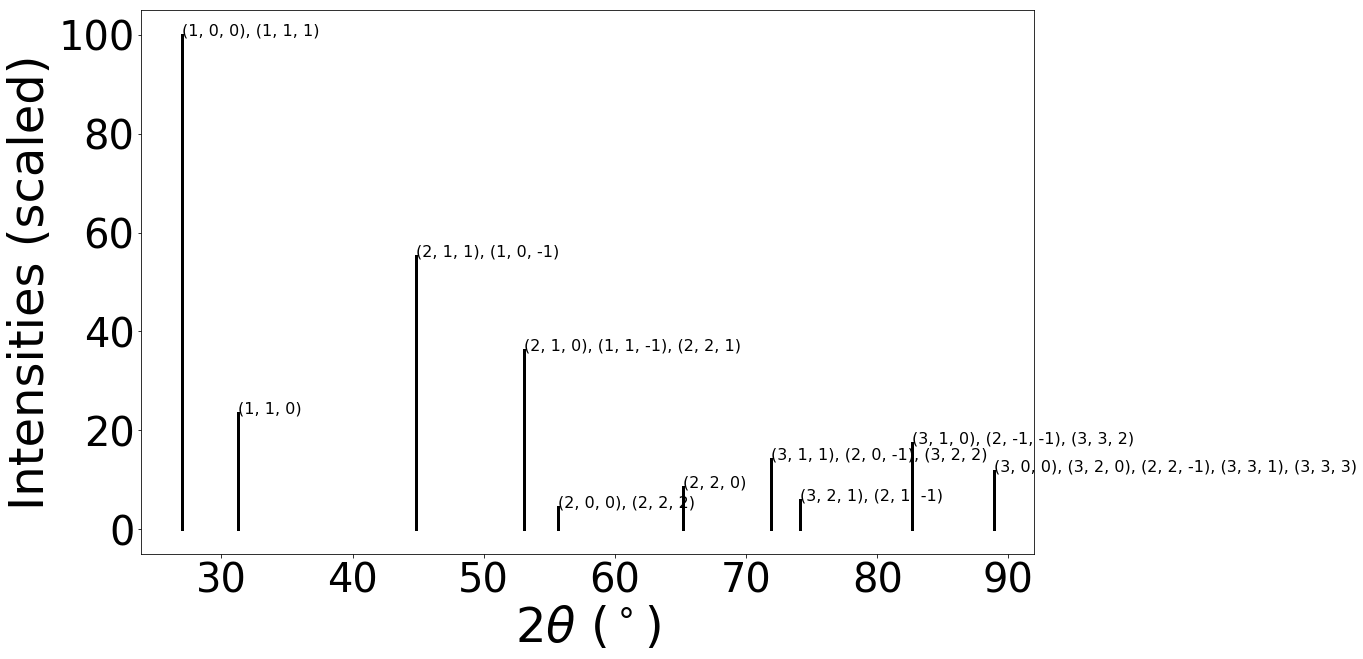

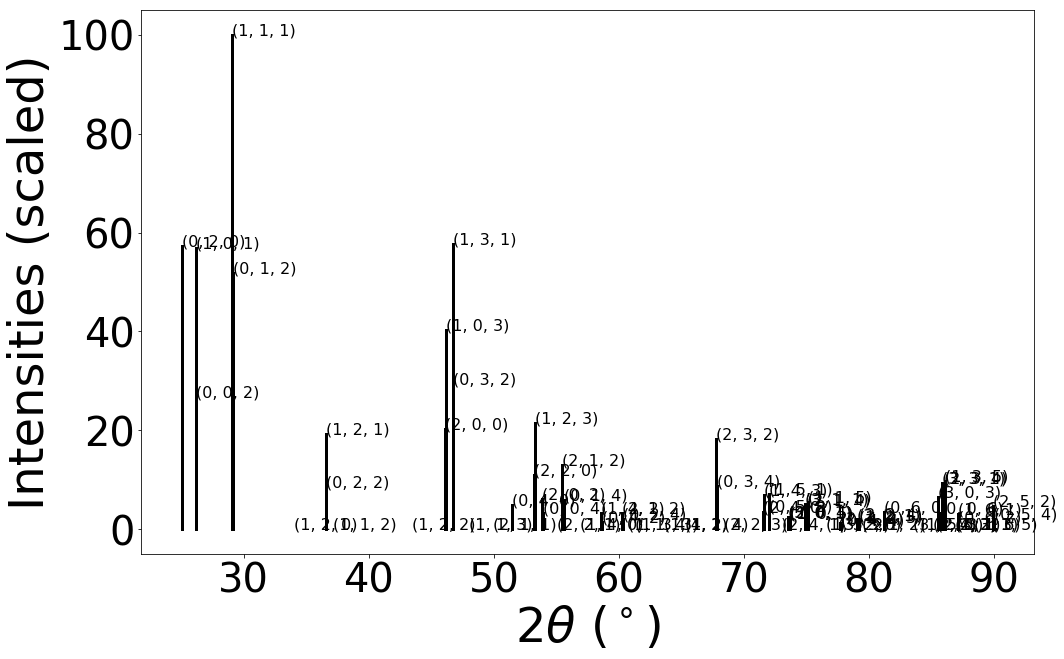

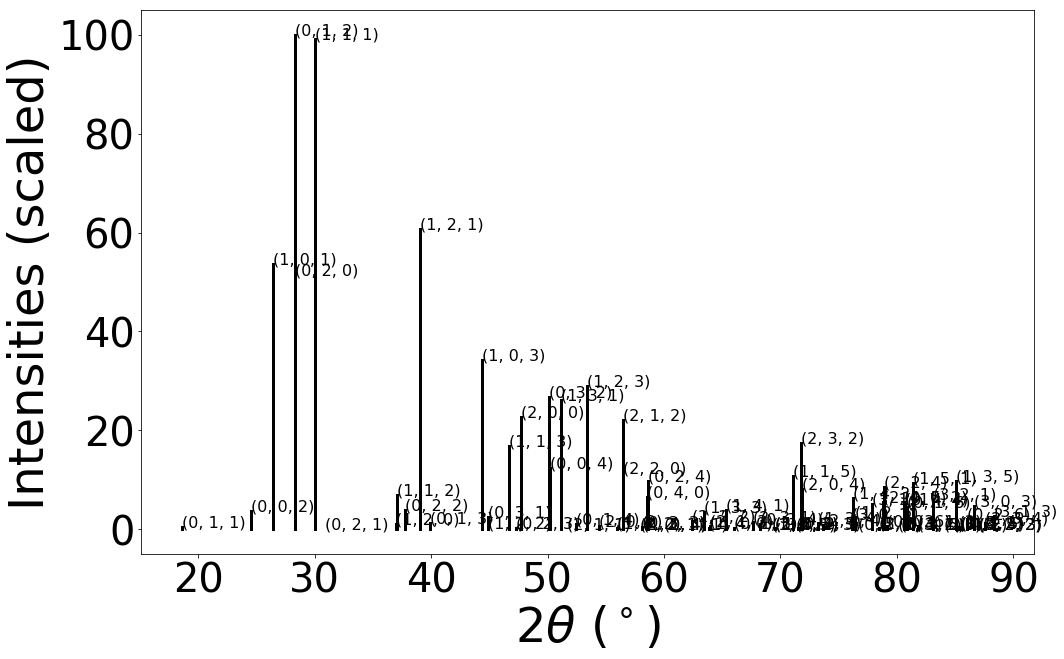

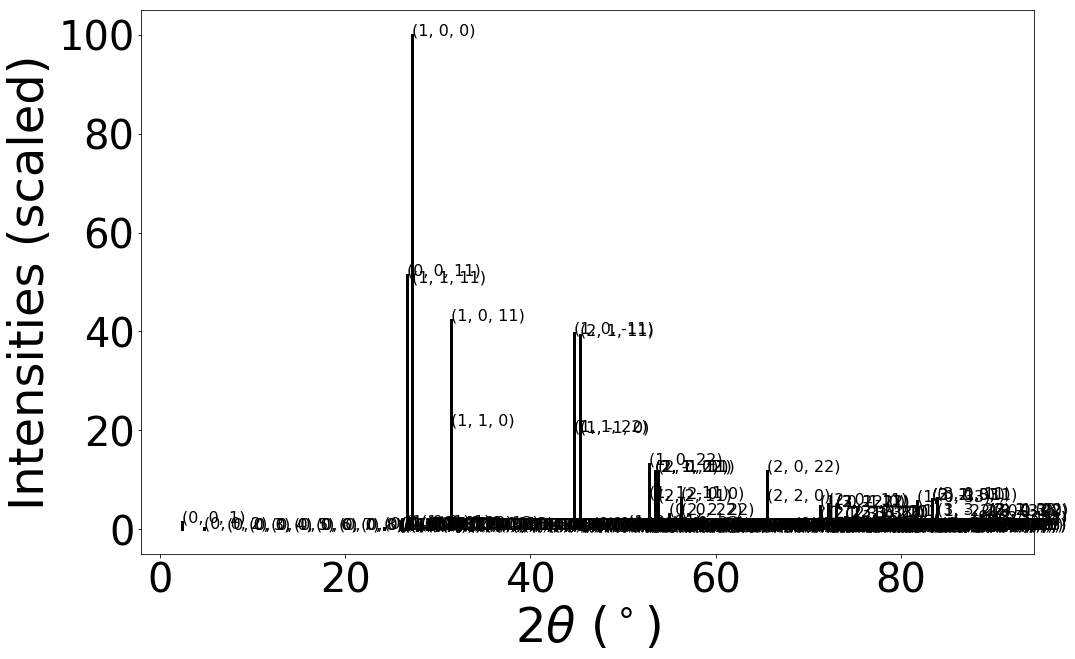

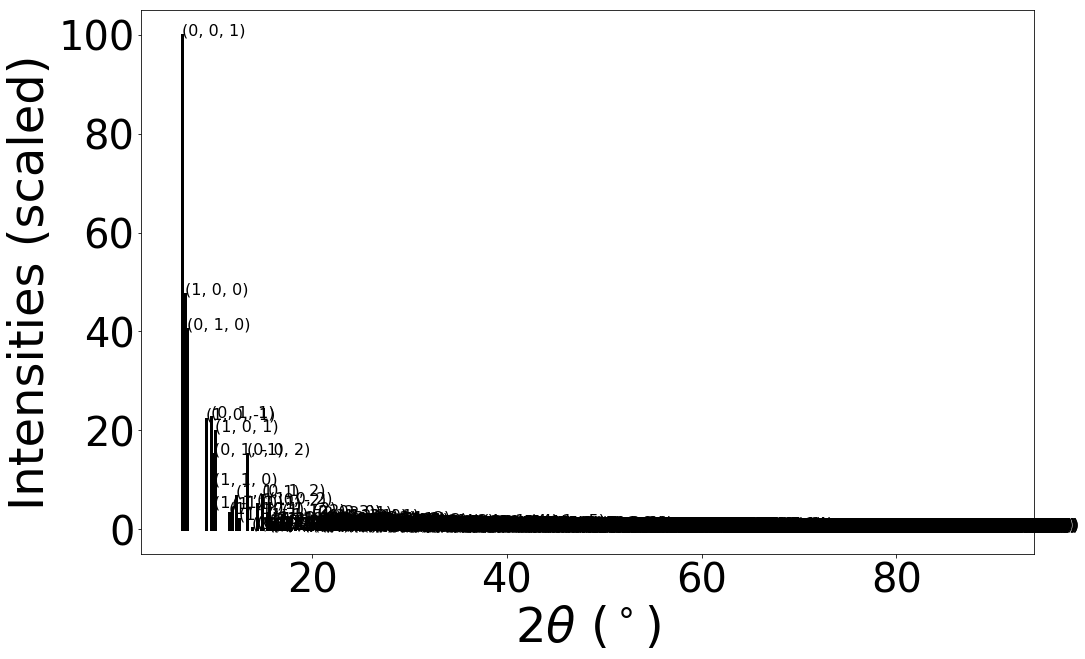

In [46]:
lis_structures = loadfn("li_s_structures.json")
#data = xrdc.get_pattern(lis_structures[0], two_theta_range=[10,80])
for n, lis_structure in enumerate(lis_structures):
    data = xrdc.get_pattern(lis_structure, two_theta_range=[10,80])
    if len(data) == 8:
        print(lis_structure)
    xrdc.get_plot(lis_structure)

## Tensors


## Exercise 2:

Fit a "noisy" tensor to a particular crystal structure

In [47]:
import json
import numpy as np
from pymatgen.analysis.elasticity.elastic import ElasticTensor
data = json.load(open("sample_elastic.json"))
si_struct = Structure.from_dict(data[0])
et = ElasticTensor.from_voigt(data[1])

print(np.array(data[1]))
et.fit_to_structure(si_struct).voigt.round(2)

[[1.4399e+02 5.3580e+01 5.3530e+01 1.3000e-01 4.1000e-01 6.0000e-02]
 [5.2890e+01 1.4362e+02 5.3180e+01 6.1000e-01 6.7000e-01 2.1000e-01]
 [5.3190e+01 5.2970e+01 1.4404e+02 2.5000e-01 5.5000e-01 1.0000e-02]
 [9.7000e-01 6.9000e-01 4.7000e-01 7.5090e+01 3.5000e-01 0.0000e+00]
 [7.7000e-01 6.8000e-01 4.1000e-01 6.0000e-02 7.4710e+01 9.2000e-01]
 [1.7000e-01 6.6000e-01 4.9000e-01 1.7000e-01 1.3000e-01 7.5070e+01]]


array([[143.88,  53.22,  53.22,   0.  ,   0.  ,  -0.  ],
       [ 53.22, 143.88,  53.22,   0.  ,   0.  ,  -0.  ],
       [ 53.22,  53.22, 143.88,   0.  ,   0.  ,  -0.  ],
       [  0.  ,   0.  ,   0.  ,  74.96,  -0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,  -0.  ,  74.96,   0.  ],
       [ -0.  ,  -0.  ,  -0.  ,   0.  ,   0.  ,  74.96]])

## Surfaces

### Generate all of the low-index facets for BCC Fe


In [50]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.surface import generate_all_slabs
lattice = Lattice.cubic(2.85)
structure = Structure(lattice, ["Fe", "Fe"],
                      [[0, 0, 0], [0.5, 0.5, 0.5]])

slabs = generate_all_slabs(structure, 1, 4, 10)
first_slab = slabs[0]
first_slab.miller_index
for slab in slabs:
    print(slab.miller_index)

(1, 1, 1)
(1, 1, 0)
(1, 0, 0)


# Summary

This notebook is intended to provide a short introduction to some of the functionality of pymatgen. Pourbaix diagram and phase diagram generation require a bit more in-depth use of the API, and we don't have time to cover that here, but you can find additional examples [here](http://pymatgen.org/examples.html).

In conclusion, I'd like to note that pymatgen development is ongoing and encourage you to get involved.  We have a [git repository](www.github.com/materialsproject/pymatgen), which you can clone/fork to customize the code.I'd encourage anyone interested in computational materials science to get a basic sense of how contributing to an open-source repository works.  You basically create a copy of the repository on github (i. e. a fork), make changes there, and submit them in what's called a pull request.